#  Aspect-Based & Opinion Mining

Problem: identify aspects and their sentiment orientation (ratings) from a set of reviews.
In this case the aspects are {food, service and location} and the reviews come from the Yelp dataset

In [ ]:
import graphlab as graphlab
from graphlab import SFrame
from graphlab import SArray
import string
from matplotlib import pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to sim.ceccarelli3@stud.uniroma3.it and will expire on April 20, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1521366749.log


In [ ]:
reviews = graphlab.SFrame.read_csv('../Datasets/yelp.csv')

Finished parsing file /home/simone/gitl/Yelp-Reviews-Analysis/Datasets/yelp.csv

Parsing completed. Parsed 100 lines in 1.84733 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,int,str,str,str,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 148 lines. Lines per second: 75.2703

Read 379 lines. Lines per second: 48.122

Read 379 lines. Lines per second: 25.532

Read 379 lines. Lines per second: 16.8279

Read 569 lines. Lines per second: 19.1558

Read 722 lines. Lines per second: 20.4405

Read 794 lines. Lines per second: 18.8623

Read 880 lines. Lines per second: 18.6259

Read 1151 lines. Lines per second: 21.8125

Read 1628 lines. Lines per second: 27.955

Read 1946 lines. Lines per second: 30.4308

Read 2803 lines. Lines per second: 39.7348

Read 3523 lines. Lines per second: 45.8614

Read 3697 lines. Lines per second: 44.8062

Read 3771 lines. Lines per second: 42.3027

Read 4127 lines. Lines per second: 43.397

Read 4443 lines. Lines per second: 44.1182

Read 4641 lines. Lines per second: 43.2635

Read 5067 lines. Lines per second: 44.672

Read 5603 lines. Lines per second: 46.9438

Read 6076 lines. Lines per second: 48.6518

Read 6320 lines. Lines per second: 48.27

Read 6320 lines. Lines per second: 45.7722

Read 6424 lines. Lines per second: 44.6673

Read 6907 lines. Lines per second: 46.0881

Read 6921 lines. Lines per second: 42.3211

Read 6921 lines. Lines per second: 39.9831

Read 6921 lines. Lines per second: 38.3293

Read 7305 lines. Lines per second: 38.5753

Read 7362 lines. Lines per second: 37.4038

Read 7362 lines. Lines per second: 36.3108

Read 7493 lines. Lines per second: 35.2347

Read 7803 lines. Lines per second: 34.9355

Read 7803 lines. Lines per second: 33.0446

Read 7827 lines. Lines per second: 31.9997

In [1]:
number_of_stars = list()
i = 0

def calculate_the_number_of_each_stars(current_review):
    print(i)
    i = i+1
    number_of_stars[current_review['stars']] += 1

map(lambda s: calculate_the_number_of_each_stars(s), reviews)

NameError: name 'reviews' is not defined

In [ ]:
number_of_stars

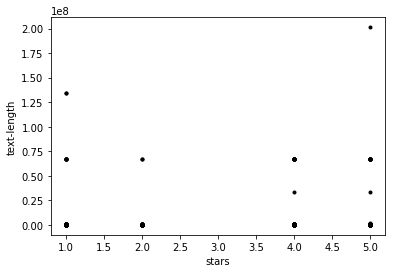

In [87]:
def plot_data(data):
    plt.plot(data['stars'], data['text-length'],'k.')
    plt.xlabel('stars')
    plt.ylabel('text-length')

plot_data( reviews )

# Text Pre-Processing

# Punctuation Removal

punctuation is removed, because for how the reviews are made it would not make any positive contribution

In [4]:
#Remove Punctuation
def remove_punctuation(text):
    return text.translate(None, string.punctuation)

reviews['text'] = reviews['text'].apply(remove_punctuation)

# Tokenization

Tokenization is the process of dividing text into a set of meaningful pieces and these pieces are called tokens.
Depending on the task at hand, we can define our own conditions to divide the input text into meaningful tokens.
it will be very useful as we will need to evaluate the individual words of each review

In [126]:
#Apply Tokenization
tokenized_reviews = graphlab.text_analytics.tokenize(reviews['text'])


# Stemming

In [127]:
#from NTLK
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [128]:
def word_stemmer(actual_word):
    ritorno = ''
    #try - except is needed because some characters are not recognized
    try:
        ritorno = stemmer.stem(actual_word)
    except UnicodeDecodeError:
        return actual_word
    return ritorno
    
    

tokenized_reviews = map(lambda s: map(lambda x: word_stemmer(x) ,s),tokenized_reviews)

In [129]:
reviews['text-tokenized'] = tokenized_reviews

# Word Count

the simplest way is to calculate the frequency of each word contained in each review

In [130]:
#Bag-of-Words dictionary, word -> word_count
dict_reviews = graphlab.text_analytics.count_words(reviews['text-tokenized'])


# Stop Words

In [131]:
#Remove stop-words
dict_reviews = dict_reviews.dict_trim_by_keys(graphlab.text_analytics.stopwords(), exclude=True)

# TF-IDF

Not all words are the same weight within reviews => give more weight to those that are characteristic for the review

In [132]:
#tf-idf using all the words in the reviews
tf_idf = graphlab.text_analytics.tf_idf(dict_reviews)
reviews['tf_idf'] = tf_idf

In [133]:
#Show result
reviews[:2]
#dict_reviews

Columns:
	business_id	str
	date	str
	review_id	str
	stars	int
	text	str
	type	str
	user_id	str
	cool	int
	useful	int
	funny	int
	text-length	int
	text-tokenized	list
	tf_idf	dict
	sentiment	int
	food	str
	service	str
	location	str

Rows: 2

Data:
+------------------------+------------+------------------------+-------+
|      business_id       |    date    |       review_id        | stars |
+------------------------+------------+------------------------+-------+
| 9yKzy9PApeiPPOUJEtnvkg | 2011-01-26 | fWKvX83p0-ka4JS3dc6E5A |   5   |
| ZRJwVLyzEJq1VAihDhYiow | 2011-07-27 | IjZ33sJrzXqU-0X6U8NwyA |   5   |
+------------------------+------------+------------------------+-------+
+-------------------------------+--------+------------------------+------+--------+
|              text             |  type  |        user_id         | cool | useful |
+-------------------------------+--------+------------------------+------+--------+
| My wife took me here on my... | review | rLtl8ZkDX5vH5nAx9C3q5Q |  2   |   5    |
| I have no idea why some pe... | review | 0a2KyEL0d3Yb1V6aivbIuQ |  0   |   0    |
+-------------------------------+--------+------------------------+------+--------+
+-------+-------------+-------------------------------+
| funny | text-length |         text-tokenized        |
+-------+-------------+-------------------------------+
|   0   |    99193    | [my, wife, took, me, here,... |
|   0   |    66881    | [i, have, no, idea, whi, s... |
+-------+-------------+-------------------------------+
+-------------------------------+-----------+-------------------------------+
|             tf_idf            | sentiment |              food             |
+-------------------------------+-----------+-------------------------------+
| {'ive': 3.7492335354248176... |     1     |  perfect absolute excellen... |
| {'pleas': 3.48787877658491... |     1     |  good baked small huge sma... |
+-------------------------------+-----------+-------------------------------+
+-------------------------------+----------------+
|            service            |    location    |
+-------------------------------+----------------+
|  semibusy earlier phenomen... |    excellent   |
|          past pleasant        |  bad great bad |
+-------------------------------+----------------+
[2 rows x 17 columns]

# Filtering of Relevant Reviews

All the reviews with 3 stars are eliminated as they tend to have a neutral sentiment

In [134]:
print("number of reviews before filtering: %d" % (len(reviews)))
reviews = reviews[reviews['stars'] != 3]
print("number of reviews after filtering: %d" % (len(reviews)))

number of reviews before filtering: 8539
number of reviews after filtering: 8539


# Natural Language Toolkit

NLTK is a platform for building python programs to work with human language data, it provides a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, and more

In [12]:
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag_sents

# Categorize and Tagging Words

in the NLP is very important the difference between nouns, verbs, adjectives, and adverbs, tagging words. so that we use NLTK to go to classify each word in one of the word classes

In [136]:
reviews['food'] = pos_tag_sents(reviews['text-tokenized'])

# Terms Relevant to Each Aspect

In [137]:
important_for_food =" menu drink breakfast plate egg spaghetti calzone pizza sauce lunch dinner cook food grub meal eat fresh veggies crisp chow victuals spread Kitchen comestibles subsistence portion provisions cheer bread"
important_for_service = " service work prices ordered favor waiting use later tune-up ceremony amenity armed forces serve servicing help serving table service overhaul religious service military service "
important_for_place = " location dog Park country show home  situation seat job status weather responsibility space shoes position spot property piazza lieu station "

In [138]:
#per verificare l'efficacia delle frasi importanti selezionate
#map(lambda s: filter(lambda c: string.find(important_for_service, c) != -1, s), reviews['text-tokenized'])


# Relevant Elements

All elements referable to an adjective or an aspect are filtered

In [140]:
reviews_with_relevant_elements = list()
def adjective_and_aspect_filter(u):
    #first think to do is remove the stop-words because it isn't removed before (in tokenized element)
    if(u[0].lower() in graphlab.text_analytics.stopwords()):
        return ''
    if(string.find(u[1], 'JJ') != -1 or (string.find(important_for_food, u[0]) != -1) or (string.find(important_for_service, u[0]) != -1) or (string.find(important_for_place, u[0]))):
        return u
    else: 
        return ''

reviews_with_relevant_elements.append(map(lambda s: map(lambda u: adjective_and_aspect_filter(u) ,s), reviews['food']))

In [141]:
#normalizzazione di reviews_with_relevant_elements
reviews_with_relevant_elements = reviews_with_relevant_elements[0]

In [142]:
#filtriamo tutti quelli != ''
reviews_with_relevant_elements = map(lambda s: filter(lambda x: x != '', s), reviews_with_relevant_elements)

# Adjectives and Keywords

In [143]:
#filtraggio dei valori con lunghezza < 3 poiche classificati erroneamente come appartenenti ad una delle 3 categorie di interesse
#questo è dovuto al fatto che noi riusciamo a classificare in una categoria anche parole scritte male
adjectives_and_keywords = map(lambda s: filter(lambda x: len(x[0]) > 2, s), reviews_with_relevant_elements)

In [144]:
#smistamento degli aggettivi per le rispettive categorie
temporary_adjectives_for_the_cooking = ''
temporary_adjectives_for_service = ''
temporary_adjectives_for_location = ''

adjectives_cooking = list()
adjectives_service = list()
adjectives_location = list()

temporary_actual_adjectives = ''


def filtra_per_cucina(actual_word):
    global temporary_adjectives_for_the_cooking, temporary_actual_adjectives, temporary_adjectives_for_location, temporary_adjectives_for_service
    if(string.find(actual_word[1],'JJ') == -1):
        if(temporary_actual_adjectives != ''):
            if(string.find(important_for_place, actual_word[0]) != -1):
                temporary_adjectives_for_location = temporary_adjectives_for_location + temporary_actual_adjectives
                temporary_actual_adjectives = ''
            else:
                if(string.find(important_for_service, actual_word[0]) != -1):
                    temporary_adjectives_for_service = temporary_adjectives_for_service + temporary_actual_adjectives
                    temporary_actual_adjectives = ''
                else:
                    if(string.find(important_for_food, actual_word[0]) != -1):
                        temporary_adjectives_for_the_cooking = temporary_adjectives_for_the_cooking + temporary_actual_adjectives
                        temporary_actual_adjectives = ''
    else:
        temporary_actual_adjectives = temporary_actual_adjectives + " " + actual_word[0]
        
def init(actual_review):
    global temporary_adjectives_for_the_cooking, temporary_adjectives_for_location, temporary_adjectives_for_service, temporary_actual_adjectives
    temporary_actual_adjectives = ''
    map(lambda x: filtra_per_cucina(x), actual_review)
    #nel caso in cui vi siano rimasti aggettivi inerenti ad una review non assegnati a nessuna categoria essi
    #verranno associati alla cucina poichè molto probabilmente si riferisce alla cucina
  
    if(temporary_actual_adjectives != ''):
        temporary_adjectives_for_the_cooking = temporary_adjectives_for_the_cooking + temporary_actual_adjectives
    
    adjectives_cooking.append(temporary_adjectives_for_the_cooking)
    adjectives_service.append(temporary_adjectives_for_service)
    adjectives_location.append(temporary_adjectives_for_location)
    
    temporary_adjectives_for_the_cooking = ''
    temporary_adjectives_for_service = ''
    temporary_adjectives_for_location = ''

aggettivi_per = map(lambda s: init(s), adjectives_and_keywords)

# Split Into Three Indipendent SFrame 

In [145]:
#da list to list ad SArray
reviews['food'] = SArray(adjectives_cooking)
reviews['service'] = SArray(adjectives_service)
reviews['location'] = SArray(adjectives_location)

In [146]:
#preparazione SFrame per ogni categoria poichè così all'atto del training si può andare a valutare per ogni 
#categoria le reviews di interesse poichè può essere che in una categoria vi siano valori nulli

#SFrame per cucina
reviews_food = graphlab.SFrame({'food': adjectives_cooking})

#SFrame per servizio
reviews_service = graphlab.SFrame({'service': adjectives_service})

#SFrame per location
reviews_location = graphlab.SFrame({'location': adjectives_location})

In [147]:
#elimino tutti quelli che hanno campo vuoto '' così che non mi vadano ad addestrare male il classificatore
reviews_service = reviews_service[reviews_service['service'] != '']
reviews_food = reviews_food[reviews_food['food'] != '']
reviews_location = reviews_location[reviews_location['location'] != '']


In [148]:
#tokenizzazione
tokenized_food = graphlab.text_analytics.tokenize(reviews_food['food'])
tokenized_service = graphlab.text_analytics.tokenize(reviews_service['service'])
tokenized_location = graphlab.text_analytics.tokenize(reviews_location['location'])

reviews_food['food_tokenized'] = tokenized_food
reviews_service['service_tokenized'] = tokenized_service
reviews_location['location_tokenized'] = tokenized_location

In [149]:
#Bag-of-Words dictionary, word -> word_count
dict_reviews_food = graphlab.text_analytics.count_words(reviews_food['food_tokenized'])
dict_reviews_service = graphlab.text_analytics.count_words(reviews_service['service_tokenized'])
dict_reviews_location = graphlab.text_analytics.count_words(reviews_location['location_tokenized'])


In [150]:
#tf-idf using all the words in the reviews
tf_idf_food = graphlab.text_analytics.tf_idf(dict_reviews_food)
tf_idf_service = graphlab.text_analytics.tf_idf(dict_reviews_service)
tf_idf_location = graphlab.text_analytics.tf_idf(dict_reviews_location)

In [151]:
reviews_food['tf_idf_food'] = tf_idf_food
reviews_service['tf_idf_service'] = tf_idf_service
reviews_location['tf_idf_location'] = tf_idf_location

# Sentiment Analisys for Every Aspect of Interest

Important for calculating the sentiment columns

In [152]:
def predictions_mean(data, topic):
    m = None
    m = graphlab.sentiment_analysis.create(data, features=topic)
    predictions = m.predict(data)
    return predictions 
    

sentiment_food = predictions_mean(reviews_food,'food')
sentiment_service = predictions_mean(reviews_service,'service')
sentiment_location = predictions_mean(reviews_location,'location')

In [153]:
reviews_food['sentiment'] = sentiment_food.apply(lambda rating: +1 if rating > 0.5 else -1 )                                      
reviews_service['sentiment'] = sentiment_service.apply(lambda rating: +1 if rating > 0.5 else -1)
reviews_location['sentiment'] = sentiment_location.apply(lambda rating: +1 if rating > 0.5 else -1)

In [ ]:
#sentiment for the reviews without the analysis of the aspects
#Introduce the sentiment -> +1 (good) for 4+ stars, -1 (bad) for 3- stars
reviews['sentiment'] = reviews['stars'].apply(lambda rating: +1 if rating > 3 else -1)

# Classificazioni

In [154]:
train_data_cucina, test_data_cucina = reviews_food.random_split(.8, seed = 0)
train_data_servizio, test_data_servizio = reviews_service.random_split(.8, seed = 0)
train_data_location, test_data_location = reviews_location.random_split(.8, seed = 0)
train_data_sentiment, test_data_sentiment = reviews.random_split(.8, seed = 0)

In [155]:
#svm_classifier
#cucina
features = ['tf_idf_food']
model_cucina = graphlab.svm_classifier.create(train_data_cucina, target = 'sentiment', 
                                       features = features,penalty=1.0, feature_rescaling = True,lbfgs_memory_level=7, max_iterations = 30)

#servizio
features = ['tf_idf_service']
model_servizio = graphlab.svm_classifier.create(train_data_servizio, target = 'sentiment', 
                                       features = features,penalty=1.0, feature_rescaling = True,lbfgs_memory_level=7, max_iterations = 30)

#location
features = ['tf_idf_location']
model_location = graphlab.svm_classifier.create(train_data_location, target = 'sentiment', 
                                       features = features,penalty=1.0, feature_rescaling = True,lbfgs_memory_level=7, max_iterations = 15)

#sentiment senza divisione del testo
#Model creation

features = ['tf_idf']
model_sentiment = graphlab.svm_classifier.create(train_data_sentiment, target = 'sentiment', 
                                       features = features,penalty=1.0, feature_rescaling = True,lbfgs_memory_level=7, max_iterations = 30)


PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

SVM:

--------------------------------------------------------

Number of examples          : 5885

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 6199

Number of coefficients    : 6200

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000170  | 0.082320     | 0.889890          | 0.894081            |

| 2         | 5        | 1.000000  | 0.159998     | 0.929312          | 0.903427            |

| 3         | 6        | 1.000000  | 0.201180     | 0.981308          | 0.912773            |

| 4         | 7        | 1.000000  | 0.248144     | 0.993713          | 0.928349            |

| 5         | 8        | 1.000000  | 0.289545     | 0.995752          | 0.931464            |

| 6         | 9        | 1.000000  | 0.327371     | 0.996262          | 0.931464            |

| 11        | 14       | 1.000000  | 0.533317     | 0.998301          | 0.931464            |

| 25        | 28       | 1.000000  | 0.983623     | 0.999490          | 0.925234            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

SVM:

--------------------------------------------------------

Number of examples          : 3612

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 3846

Number of coefficients    : 3847

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000277  | 0.050840     | 0.895072          | 0.890710            |

| 2         | 5        | 1.000000  | 0.090396     | 0.946567          | 0.907104            |

| 3         | 6        | 1.000000  | 0.117736     | 0.988095          | 0.928962            |

| 4         | 7        | 1.000000  | 0.141021     | 0.993909          | 0.928962            |

| 5         | 8        | 1.000000  | 0.170157     | 0.995570          | 0.928962            |

| 6         | 9        | 1.000000  | 0.191363     | 0.996124          | 0.928962            |

| 11        | 14       | 1.000000  | 0.299686     | 0.997508          | 0.934426            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



This model may not be optimal. To improve it, consider increasing `max_iterations`.

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

SVM:

--------------------------------------------------------

Number of examples          : 2468

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 2922

Number of coefficients    : 2923

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000405  | 0.044219     | 0.913290          | 0.921429            |

| 2         | 5        | 1.000000  | 0.067330     | 0.962318          | 0.921429            |

| 3         | 6        | 1.000000  | 0.082679     | 0.990681          | 0.921429            |

| 4         | 7        | 1.000000  | 0.095090     | 0.997164          | 0.928571            |

| 5         | 8        | 1.000000  | 0.106600     | 0.997974          | 0.928571            |

| 6         | 9        | 1.000000  | 0.118469     | 0.999595          | 0.921429            |

| 11        | 14       | 1.000000  | 0.177430     | 0.999595          | 0.928571            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



This model may not be optimal. To improve it, consider increasing `max_iterations`.

WARNING: The number of feature dimensions in this problem is very large in comparison with the number of examples. Unless an appropriate regularization value is set, this model may not provide accurate predictions for a validation/test set.

SVM:

--------------------------------------------------------

Number of examples          : 6520

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 28582

Number of coefficients    : 28583

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 5        | 0.000038  | 0.292410     | 0.807515          | 0.790368            |

| 2         | 8        | 5.000000  | 0.504093     | 0.923006          | 0.796034            |

| 3         | 9        | 5.000000  | 0.614715     | 0.838804          | 0.790368            |

| 4         | 11       | 1.000000  | 0.789772     | 0.948160          | 0.815864            |

| 5         | 12       | 1.000000  | 0.909480     | 0.986503          | 0.889518            |

| 6         | 13       | 1.000000  | 1.025183     | 0.991871          | 0.909348            |

| 10        | 17       | 1.000000  | 1.415307     | 0.997393          | 0.900850            |

| 11        | 18       | 1.000000  | 1.533334     | 0.997546          | 0.900850            |

| 20        | 27       | 1.000000  | 2.368409     | 0.998313          | 0.898017            |

| 30        | 39       | 1.000000  | 3.367512     | 0.998773          | 0.892351            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [156]:
def calculate_classification_test(test_data, model):
    predictions_margin = model.predict(test_data, output_type = 'margin')
    predictions_sign = model.predict(test_data)
    test_data['prediction_margin'] = predictions_margin
    test_data['prediction_sign'] = predictions_sign

calculate_classification_test(test_data_cucina, model_cucina)
calculate_classification_test(test_data_servizio, model_servizio)
calculate_classification_test(test_data_location, model_location)
calculate_classification_test(test_data_sentiment, model_sentiment)

# Accuracy

In [157]:
#accuratezza
def accuracy(test_data):
    num_correct = sum(test_data['sentiment'] == test_data['prediction_sign'])
    nc = float(num_correct)
    accuracy = nc / len(test_data)
    return float(accuracy)

accuracy = SFrame({'Food': [accuracy(test_data_cucina)], 'Service': [accuracy(test_data_servizio)], 'Location': [accuracy(test_data_location)], 'Sentiment': [accuracy(test_data_sentiment)]})

In [158]:
accuracy

Food,Location,Sentiment,Service
0.92809587217,0.911214953271,0.874549819928,0.926486486486


run
